In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from xgboost.sklearn import XGBClassifier 
from sklearn import metrics
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import binom
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn import datasets, svm

%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# read in ANES survey data
data = pd.read_csv('../Capstone/data/ANES_2016_pilot.csv')
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


In [3]:
# check values counts vote
data['vote'].value_counts()

clinton         215
trump           158
someone_else     48
Name: vote, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 3 columns):
vote        421 non-null object
age         421 non-null int64
party_id    421 non-null object
dtypes: int64(1), object(2)
memory usage: 9.9+ KB


In [5]:
# check values counts for party id
data['party_id'].value_counts()

democrat       186
independent    138
republican      97
Name: party_id, dtype: int64

In [53]:
# check value counts by age
data['age'].value_counts()

62    19
56    16
55    12
38    11
57    11
60    11
52    10
67    10
35    10
28    10
63    10
64    10
39     9
43     9
30     9
42     8
59     8
65     8
54     8
34     8
20     8
27     7
49     7
22     7
21     7
24     7
44     7
29     7
32     7
31     7
      ..
71     6
37     5
41     5
58     5
46     5
48     5
78     5
68     5
80     4
23     4
70     4
51     4
53     4
77     3
76     3
75     3
66     3
72     3
50     3
19     2
45     2
73     2
79     2
83     2
47     1
91     1
81     1
82     1
84     1
95     1
Name: age, Length: 68, dtype: int64

In [7]:
data = pd.get_dummies(data, columns=['vote', 'party_id'])

In [8]:
data.head()

,age,vote_clinton,vote_someone_else,vote_trump,party_id_democrat,party_id_independent,party_id_republican
0,56,1,0,0,1,0,0
1,65,0,0,1,0,0,1
2,80,1,0,0,1,0,0
3,38,0,0,1,0,0,1
4,60,0,0,1,0,0,1


## Scaling

In [9]:
# create target and features dataframes
y = data['vote_trump']
X = data[['age', 'party_id_democrat', 'party_id_independent', 'party_id_republican']]

In [10]:
# scale my data
ss = StandardScaler()
X_scaled = ss.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()

/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,age,party_id_democrat,party_id_independent,party_id_republican
0,0.413424,1.124029,-0.698307,-0.547159
1,0.940852,-0.889657,-0.698307,1.827623
2,1.819900,1.124029,-0.698307,-0.547159
3,-0.641433,-0.889657,-0.698307,1.827623
4,0.647836,-0.889657,-0.698307,1.827623


## Train, test, split

In [11]:
# train test split plus scaled tts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(X_scaled_df, y)

## Logistic Regression

In [12]:
# instantiate Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# print intercept and coefs
print('Intercept:', logreg.intercept_)
print('Coef(s):', logreg.coef_)

Intercept: [-0.68667356]
Coef(s): [[ 0.01340472 -1.88487091 -0.06590771  1.26410505]]


/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [13]:
# print first five predictions
print('Logreg predicted probabilities:', logreg.predict(X_train.head(5)))

Logreg predicted probabilities: [0 0 0 0 1]


In [14]:
# print probablities for first five predictions
print('Logreg predicted probabilities:', logreg.predict_proba(X_train.head(5)))

Logreg predicted probabilities: [[0.84556576 0.15443424]
 [0.5571978  0.4428022 ]
 [0.58672418 0.41327582]
 [0.8606717  0.1393283 ]
 [0.2496995  0.7503005 ]]


In [15]:
# fit and score model
logreg.fit(X_train, y_train)
print(logreg.score(X_train, y_train))
print(logreg.score(X_test, y_test))

0.7755102040816326
0.8188976377952756


/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [54]:
preds = logreg.predict_proba(X_test)[:,1]
print('\n LogReg ROC AUC')
roc_auc_score(y_test, preds)


 LogReg ROC AUC


0.8744523548740416

## Random Forest

In [16]:
# instaniate Random Forest
forest = RandomForestClassifier(max_depth=10, n_estimators=5, class_weight="balanced")

In [17]:
# fit Random Forest and check scores
forest.fit(X_train, y_train)
# score model
print('\n Random Forest')
print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))



 Random Forest
0.8197278911564626
0.7716535433070866


In [18]:
# use predictions to get roc auc score
preds = forest.predict_proba(X_test)[:,1]
print('\n Random Forest ROC AUC')
roc_auc_score(y_test, preds)


 Random Forest ROC AUC


0.8198247535596934

## SMOTE

In [19]:
# instantiate SMOTE and fit sample
sm = SMOTE()
X_resample, y_resample = sm.fit_sample(X_train, y_train)
X_scaled_res, y_scaled_res = sm.fit_sample(X_scaled_train, y_scaled_train)

## Support Vector Classifier

In [20]:
# instantiate SVC
svc = SVC(kernel='linear', probability=True)
svc.fit(X_resample, y_resample)
# score model
print('\n Support Vector Classifier')
svc.score(X_test, y_test)


 Support Vector Classifier


0.7480314960629921

In [21]:
preds = svc.predict_proba(X_test)[:,1]
print('\n Support Vector Classifier ROC AUC')
roc_auc_score(y_test, preds)


 Support Vector Classifier ROC AUC


0.8128422782037239

## XGBoost

In [22]:
X_resample = pd.DataFrame(X_resample, columns=X_train.columns)
y_resample = pd.DataFrame(y_resample)

In [23]:
model = XGBClassifier()
xgm = model.fit(X_resample, y_resample, eval_metric=roc_auc_score)
# score model
print('\n XGBoost')
xgm.score(X_test, y_test)

/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 XGBoost


0.8110236220472441

In [24]:
preds = xgm.predict_proba(X_test)[:,1]
print('\n XGBoost ROC AUC')
roc_auc_score(y_test, preds)


 XGBoost ROC AUC


0.8478915662650603

In [25]:
X_scaled_res = pd.DataFrame(X_scaled_res, columns=X_train.columns)
y_scaled_res = pd.DataFrame(y_scaled_res)

In [26]:
model = XGBClassifier()
xgm_scaled = model.fit(X_scaled_res, y_scaled_res, eval_metric=roc_auc_score)
# score model
print('\n XGBoost scaled')
xgm_scaled.score(X_scaled_test, y_scaled_test)


 XGBoost scaled


/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6981132075471698

In [27]:
preds = xgm_scaled.predict_proba(X_test)[:,1]
print('\n XGBoost ROC AUC')
roc_auc_score(y_test, preds)


 XGBoost ROC AUC


0.8491237677984665

## AdaBoost

In [28]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)
ada.fit(X_resample, y_resample)
# score model
print('\n AdaBoost')
ada.score(X_test, y_test)

/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 AdaBoost


0.7874015748031497

In [29]:
def plot_coefficients(classifier, feature_names, top_features=4):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # Plot them thangs. 
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(0, 2 * top_features),
        feature_names[top_coefficients],
        rotation=60, ha='right')

In [30]:
sorted(list(zip(*svc.coef_, X_train.columns)))

[(-2.000745985841423, 'party_id_democrat'),
 (-0.00038694328243282783, 'party_id_republican'),
 (-0.00022959559342794478, 'party_id_independent'),
 (8.160058143857896e-06, 'age')]

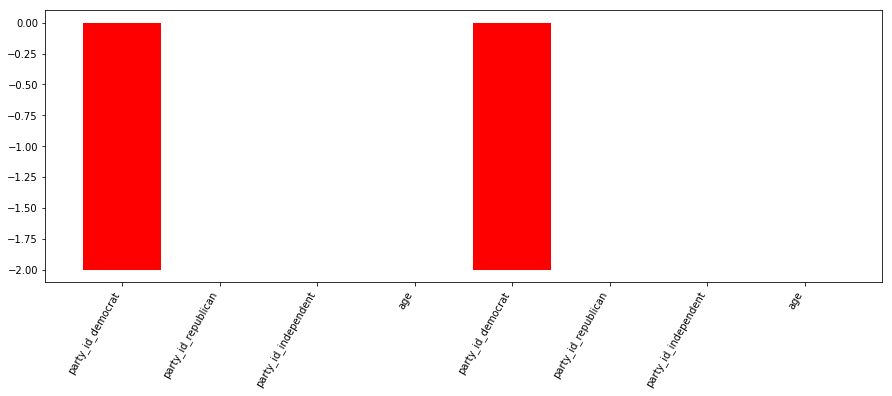

In [31]:
plot_coefficients(svc, X_train.columns)

In [32]:
sorted(list(zip(*logreg.coef_, X_train.columns)))

[(-1.8848709077565744, 'party_id_democrat'),
 (-0.0659077065395537, 'party_id_independent'),
 (0.013404721232437558, 'age'),
 (1.2641050526235642, 'party_id_republican')]

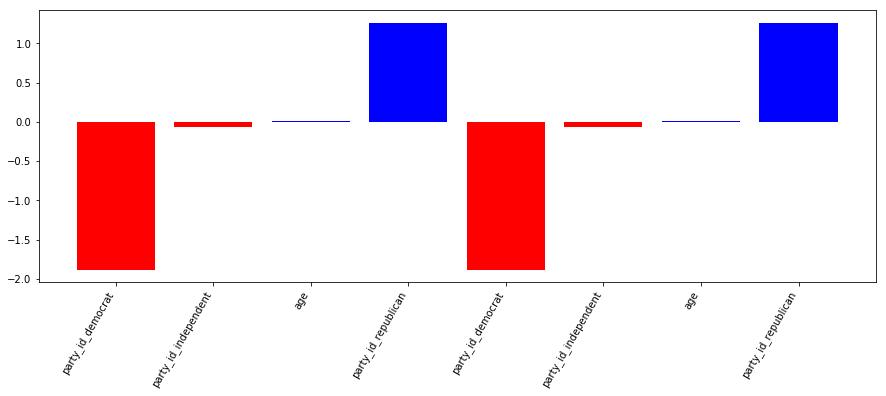

In [48]:
plot_coefficients(logreg, X_train.columns, top_features=4)

In [35]:
def plot_importances(classifier, feature_names, top_features=4, tree_based=False):
    coef = classifier.feature_importances_.ravel()
    top_importances = np.argsort(coef)[-top_features:]
    # create plot
    plt.figure(figsize=(15, 5))
    plt.bar(np.arange(top_features), coef[top_importances], color='blue')
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(0, top_features),
        feature_names[top_importances],
        rotation=60, ha='right')

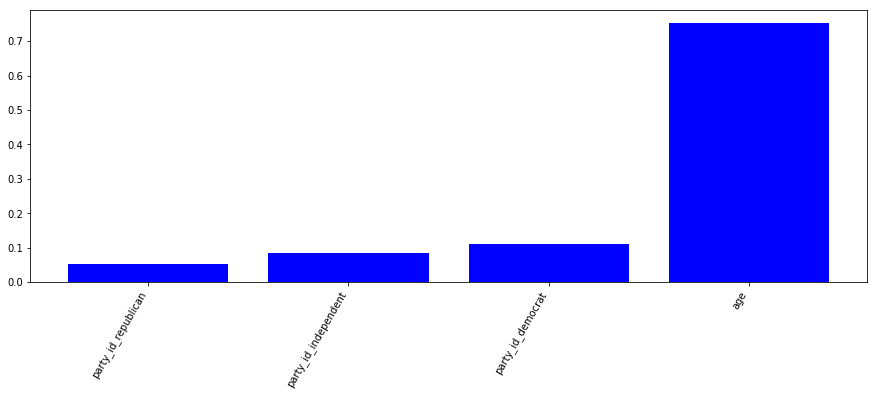

In [36]:
plot_importances(xgm, X_train.columns)

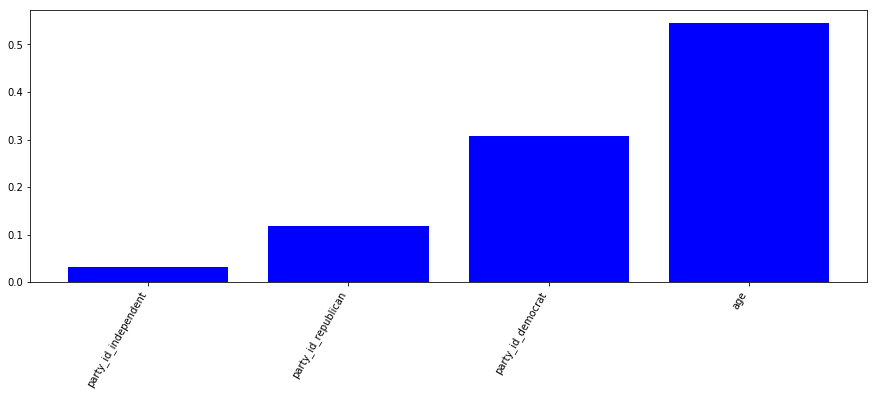

In [37]:
plot_importances(forest, X_train.columns)

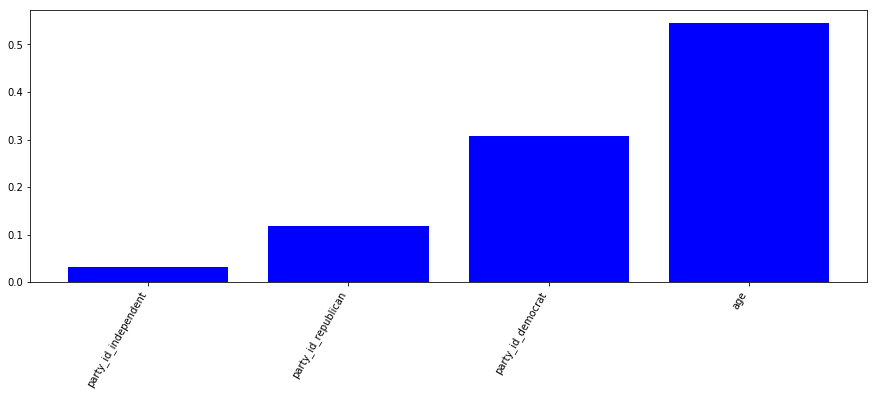

In [38]:
plot_importances(forest, X_train.columns)

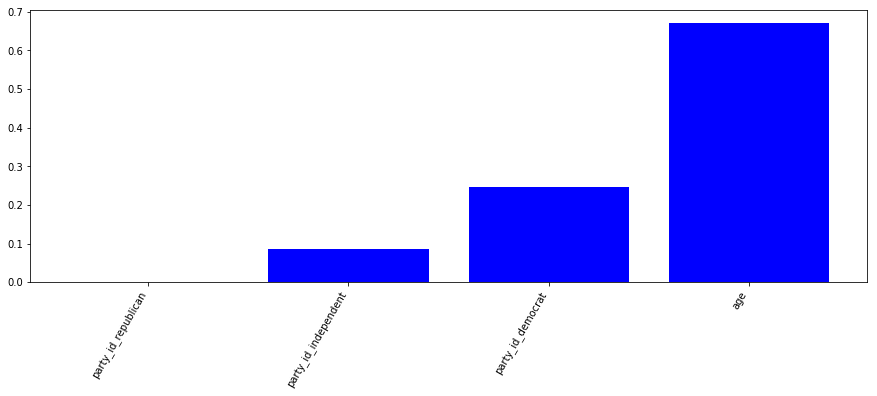

In [39]:
plot_importances(ada, X_train.columns)

In [40]:
data.head()

,age,vote_clinton,vote_someone_else,vote_trump,party_id_democrat,party_id_independent,party_id_republican
0,56,1,0,0,1,0,0
1,65,0,0,1,0,0,1
2,80,1,0,0,1,0,0
3,38,0,0,1,0,0,1
4,60,0,0,1,0,0,1


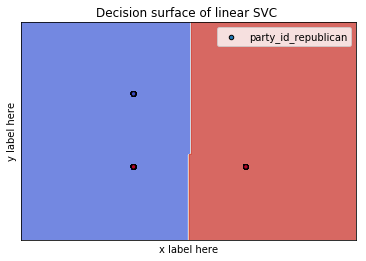

In [41]:



# Select 2 features / variable for the 2D plot that we are going to create.
X = data[['party_id_democrat', 'party_id_republican']]  # we only take the first two features.
y = data['vote_clinton']

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

model = svm.SVC(kernel='linear')
clf = model.fit(X, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X['party_id_democrat'], X['party_id_republican']
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

In [42]:
s = np.random.binomial(421, .51, 1000)

/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[Text(0,0.5,'Frequency'), Text(0.5,0,'Binomial')]

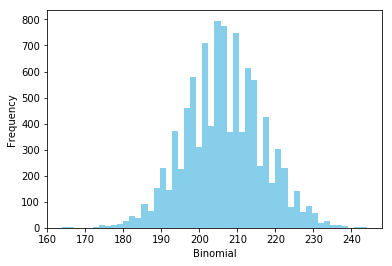

In [46]:
data_binom = binom.rvs(n=421,p=0.49,size=10000)
ax = sns.distplot(data_binom,
                  kde=False,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Binomial', ylabel='Frequency')

/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[Text(0,0.5,'Frequency'), Text(0.5,0,'Binomial')]

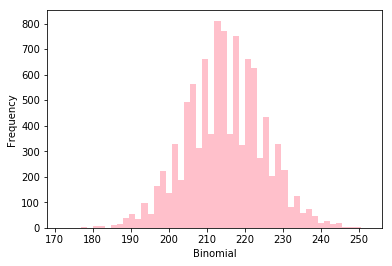

In [45]:
data_binom = binom.rvs(n=421,p=0.51,size=10000)
ax = sns.distplot(data_binom,
                  kde=False,
                  color='pink',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Binomial', ylabel='Frequency')